In [57]:
# Import libraries
import scipy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas import DataFrame
from pandas import Series
from pandas import concat


# Loading Data

In [58]:
####### Loading data for batteries #########

def data_loading(filename, inrelevant_features):
    raw_data = pd.read_json(filename)
    df = raw_data.copy()
    df = df.T
    
    useful_df = df.drop(inrelevant_features, axis = 1)
    
    ### index 
    useful_df.index = range(len(useful_df))
    useful_df.index = useful_df.index
    
    ## change from df to series
    series = useful_df.squeeze()
    
    return useful_df, series
    
    

In [59]:
# loading data test
filename_5 = 'B0005_discharge.json'
filename_6 = 'B0006_discharge.json'
filename_7 = 'B0007_discharge.json'
filename_18 = 'B0018_discharge.json'
inre_features = ['date_time', 'voltage_battery', 'current_battery', 'temp_battery', 'amb_temp', 'current_load', 'voltage_load', 'time']
capacity_df_5, _ = data_loading(filename_5, inre_features)
capacity_df_6, _ = data_loading(filename_6, inre_features)
capacity_df_7, _ = data_loading(filename_7, inre_features)
capacity_df_18, _ = data_loading(filename_18, inre_features)

def toFloat(x):
    return x[0]
capacity_df_5['capacity'] = capacity_df_5['capacity'].map(toFloat)
capacity_df_6['capacity'] = capacity_df_6['capacity'].map(toFloat)
capacity_df_7['capacity'] = capacity_df_7['capacity'].map(toFloat)
capacity_df_18['capacity'] = capacity_df_18['capacity'].map(toFloat)





TypeError: 'int' object is not callable

In [60]:
capacity_df_5

,capacity
0,1.856487
1,1.846327
2,1.835349
3,1.835263
4,1.834646
...,...
163,1.293464
164,1.288003
165,1.287453
166,1.309015


In [61]:
### def: draw one time_series plot ###

def timeseries(x_axis, y_axis, x_label, y_label):
    """_summary_

    Args:
        x_axis (_type_): _description_
        y_axis (_type_): _description_
        x_label (_type_): _description_
        y_label (_type_): _description_
    """
    plt.figure(figsize=(10,6))
    plt.plot(x_axis, y_axis, color='black')
    plt.xlabel(x_label, {'fontsize':12})
    plt.ylabel(y_label, {'fontsize':12})
    

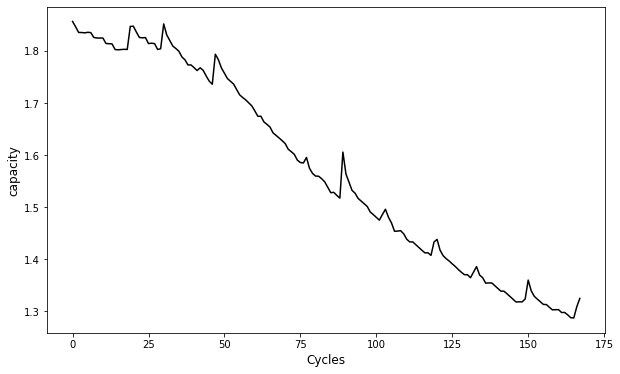

In [6]:
timeseries(capacity_df_5.index, capacity_df_5['capacity'], 'Cycles', 'capacity')

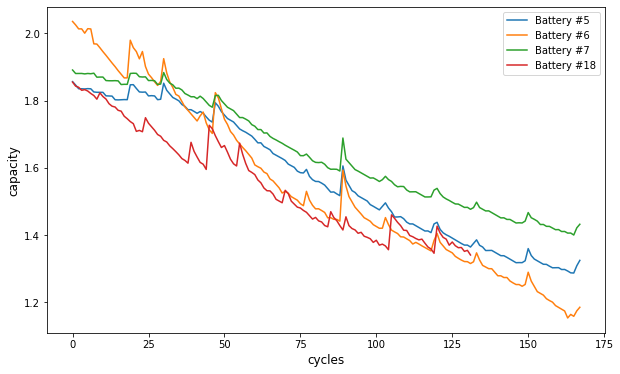

In [7]:
# multiple batteries
plt.figure(figsize=(10,6))
plt.plot(capacity_df_5.index, capacity_df_5['capacity'], label='Battery #5')
plt.plot(capacity_df_6.index, capacity_df_6['capacity'], label ='Battery #6')
plt.plot(capacity_df_7.index, capacity_df_7['capacity'], label = 'Battery #7')
plt.plot(capacity_df_18.index, capacity_df_18['capacity'], label = 'Battery #18')
plt.xlabel('cycles', {'fontsize':12})
plt.ylabel('capacity', {'fontsize':12})
plt.legend()
plt.show()

# Data Processing

In [8]:
#### Detecting non-stationarity statistically ######

from statsmodels.tsa.stattools import adfuller 

def detect_stationarity(dataset):
    test_results = adfuller(dataset)
    return test_results

c:\Users\haidlu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\haidlu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [9]:
test_results = detect_stationarity(capacity_df_5["capacity"])
print(f"p-value: {test_results[1]}")

p-value: 0.8869061026357303


In [10]:
##### def: transform the data into stationary ##############

def transform_into_stationary(df):
    df = df.diff()
    df = df.dropna()
    return df

In [11]:
#### def: reverse diff()
def inverse_dif(observations, diff):
    dif = diff 
    #dif.index -= 1
    #observations.index += 1
    obs = observations
    obs.index += 1 
    inverse = obs + dif
    return inverse

In [12]:
capacity_df_5

,capacity
0,1.856487
1,1.846327
2,1.835349
3,1.835263
4,1.834646
...,...
163,1.293464
164,1.288003
165,1.287453
166,1.309015


In [13]:
dif = transform_into_stationary(capacity_df_5)

In [14]:
test_results = detect_stationarity(dif["capacity"])
print(f"p-value: {test_results[1]}")

p-value: 1.7041928511238572e-19


In [15]:
dif

,capacity
1,-0.010160
2,-0.010978
3,-0.000087
4,-0.000617
5,0.001016
...,...
163,-0.004610
164,-0.005460
165,-0.000551
166,0.021563


In [16]:
###### Normalization #########

def normalization(dataset):
    """ to normalize the dataset between (0, 1)
    input a dataframe, output the normalized dataframe

    Args:
        dataset (dataframe): the data to be normalized
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    input_scaler = scaler.fit(dataset.values)
    norm_data = input_scaler.transform(dataset.values)
    norm_data = pd.DataFrame(norm_data)
    return norm_data


In [17]:
### test for normalization ####
norm_data = normalization(dif)

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler = scaler.fit(dif.values)
norm_data = input_scaler.transform(dif.values)
norm_data = pd.DataFrame(norm_data)

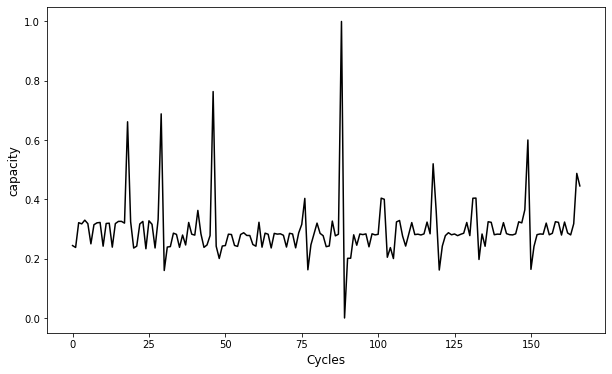

In [19]:
norm_data.columns=['capacity']
timeseries(norm_data.index, norm_data['capacity'], 'Cycles', 'capacity')

In [20]:
norm_data

,capacity
0,0.244121
1,0.237844
2,0.321429
3,0.317359
4,0.329893
...,...
162,0.286716
163,0.280190
164,0.317867
165,0.487577


In [21]:
########## def: Divide the dataset into train and test ##########


def divide_train_test(dataset, split_fraction):
    """_summary_

    Args:
        dataset (_type_): _description_
        split_fraction (_type_): _description_

    Returns:
        _type_: _description_
    """
    train_length = int(split_fraction * int(dataset.shape[0]))
    train_data = dataset.loc[0: train_length - 1]
    test_data = dataset.loc[train_length : ]
    return train_data, test_data
    

In [22]:
train_data, test_data = divide_train_test(norm_data, split_fraction=0.8)


In [23]:
print(train_data)

     capacity
0    0.244121
1    0.237844
2    0.321429
3    0.317359
4    0.329893
..        ...
128  0.285843
129  0.322062
130  0.277789
131  0.403877
132  0.404361

[133 rows x 1 columns]


In [24]:
print(test_data)

     capacity
133  0.197296
134  0.283206
135  0.241814
136  0.324548
137  0.322572
138  0.280737
139  0.282757
140  0.282204
141  0.321505
142  0.284429
143  0.280942
144  0.280088
145  0.283709
146  0.324376
147  0.320764
148  0.364913
149  0.600287
150  0.164070
151  0.241497
152  0.281001
153  0.283413
154  0.282504
155  0.319999
156  0.280606
157  0.285540
158  0.324584
159  0.322499
160  0.279709
161  0.323525
162  0.286716
163  0.280190
164  0.317867
165  0.487577
166  0.445376


Dimension of train data:  (133, 1)
Dimension of test data:  (34, 1)


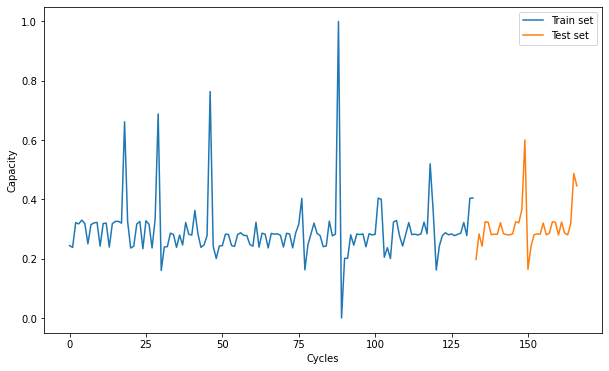

In [25]:
########################## Plotting dataset #######################

plt.figure(figsize = (10, 6))
plt.plot(train_data)
plt.plot(test_data)
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',train_data.shape)
print('Dimension of test data: ', test_data.shape)

In [26]:
####### Timeseries dataset from array example #######

def timeseries_dataset_preparation(dataset_array, look_back=1):
    """
    
    Creates tensorflow timeseries dataset from numpy array to be used in model.fit(). 
    
    This function creates a dataset where each element is a tuple `(inputs, targets)` where:
    -- `inputs` (data_X) is a Tensor of shape `(batch_size, look_back, 1)` containing the `look_back` 
    past values of the timeseries for each sample.
    -- `targets` (data_Y) is a Tensor of shape `(batch_size, 1)` containing the future value of the timeseries 
    for each sample.

    Args:
        dataset_array (np.array): array with the shape `(num_time_steps)`.
        look_back (int): length of the input sequence (in number of timesteps).

    Returns:
        A tf.data.Dataset instance, data_X, data_Y
        
    Notes: 
    1) This function requires tensorflow imorted as tf.
    2) It reshapes the dataset to be [samples, time steps, features].
    3) Use 'ds' as 'model.fit(ds,...)'.
    
    """
    num_samples = dataset_array.shape[0] - look_back
    ds_input_data = dataset_array # dataset_array[:-1]
    ds_targets = dataset_array[look_back:] 

    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    ds_input_data, ds_targets, sequence_length=look_back, batch_size=num_samples)
    
    # Exctract data_X and data_Y
    for data_X, data_Y in ds:
        data_X = data_X.numpy()
        data_Y = data_Y.numpy()
        return ds, data_X, data_Y
#---------------------------------

In [27]:
## timeseries_dataset_preparation test
train_ds, train_data_X, train_data_Y = timeseries_dataset_preparation(train_data, 10)
print(train_data_X.shape)
test_ds, test_data_X, test_data_Y = timeseries_dataset_preparation(test_data, 10)
print(test_data_X.shape)


(123, 10, 1)
(24, 10, 1)


In [28]:
test_data_Y

array([[0.28094215],
       [0.28008809],
       [0.28370882],
       [0.32437588],
       [0.32076361],
       [0.36491302],
       [0.60028712],
       [0.16407006],
       [0.24149717],
       [0.28100137],
       [0.28341343],
       [0.28250375],
       [0.31999873],
       [0.28060583],
       [0.28554044],
       [0.32458425],
       [0.32249873],
       [0.27970873],
       [0.32352509],
       [0.28671604],
       [0.28019024],
       [0.31786676],
       [0.48757713],
       [0.44537632]])

In [29]:
test_data

,capacity
133,0.197296
134,0.283206
135,0.241814
136,0.324548
137,0.322572
138,0.280737
139,0.282757
140,0.282204
141,0.321505
142,0.284429


# Building Model

In [30]:
# Create LSTM model
def create_model(units, X_train):
    model = Sequential()
    model.add(LSTM(units,
                   return_sequences = True,
                   input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.1))
    model.add(LSTM(units = units))
    model.add(Dropout(0.1))
    model.add(Dense(units = 1))
    
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

    

In [31]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
    
    history = model.fit(train_data_X, train_data_Y, epochs = 100, validation_split = 0.2, batch_size = 32, shuffle = False, callbacks=[early_stop])
    return history

In [32]:
model_lstm = create_model(32, train_data_X)

In [33]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
4/4 [==============================] - 4s 279ms/step - loss: 0.1107 - val_loss: 0.0726
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0685 - val_loss: 0.0369
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0361 - val_loss: 0.0121
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0167 - val_loss: 0.0049
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0171 - val_loss: 0.0111
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0241 - val_loss: 0.0075
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0163 - val_loss: 0.0046
Epoch 8/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0144 - val_loss: 0.0054
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0157 - val_loss: 0.0061
Epoch 10/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0142 - val_loss: 0.0056
Epoch 11/100
4/4 [

In [34]:
#### Plotting function ######
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('cycles')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

In [35]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [36]:
train_data_Y = scaler.inverse_transform(train_data_Y)
test_data_Y = scaler.inverse_transform(test_data_Y)

In [37]:
# Make prediction
def prediction(model):
    prediction = model.predict(test_data_X)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_lstm = prediction(model_lstm)

In [38]:
test_data_Y

array([[-5.36224506e-03],
       [-5.47353169e-03],
       [-5.00174038e-03],
       [ 2.97284820e-04],
       [-1.73403561e-04],
       [ 5.57938214e-03],
       [ 3.62492544e-02],
       [-2.05909899e-02],
       [-1.05020303e-02],
       [-5.35452901e-03],
       [-5.04023075e-03],
       [-5.15876462e-03],
       [-2.73068688e-04],
       [-5.40606875e-03],
       [-4.76307605e-03],
       [ 3.24437263e-04],
       [ 5.26879617e-05],
       [-5.52296322e-03],
       [ 1.86425042e-04],
       [-4.60989185e-03],
       [-5.46022123e-03],
       [-5.50870481e-04],
       [ 2.15628421e-02],
       [ 1.60639644e-02]])

In [39]:
prediction_lstm

array([[-0.00414344],
       [-0.00378524],
       [-0.00372577],
       [-0.0035785 ],
       [-0.0037753 ],
       [-0.00392556],
       [-0.00396566],
       [-0.00430805],
       [-0.00368112],
       [-0.0032281 ],
       [-0.0028861 ],
       [-0.00271214],
       [-0.00266699],
       [-0.00278586],
       [-0.00298356],
       [-0.00317049],
       [-0.00354078],
       [-0.00450765],
       [-0.00397967],
       [-0.00378825],
       [-0.00366374],
       [-0.00354571],
       [-0.0035219 ],
       [-0.00389206]], dtype=float32)

In [40]:
print(test_data_Y.shape)
print(prediction_lstm.shape)

(24, 1)
(24, 1)


In [41]:
capacity_df_5

,capacity
0,1.856487
1,1.846327
2,1.835349
3,1.835263
4,1.834646
...,...
163,1.293464
164,1.288003
165,1.287453
166,1.309015


In [42]:
len(test_data_Y)

24

In [43]:
#### reverse diff() ######
test1 = capacity_df_5[-25:-1]
test1

,capacity
143,1.334007
144,1.328644
145,1.323171
146,1.318169
147,1.318466
148,1.318293
149,1.323872
150,1.360122
151,1.339531
152,1.329029


In [44]:
test2 = test_data_Y + test1
test2

,capacity
143,1.328644
144,1.323171
145,1.318169
146,1.318466
147,1.318293
148,1.323872
149,1.360122
150,1.339531
151,1.329029
152,1.323674


In [45]:
len = len(test_data_Y)
observation = capacity_df_5[-1-len: -1]
predictict = prediction_lstm + observation
y_test = test_data_Y + observation

In [46]:
# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = prediction.shape[0]
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    

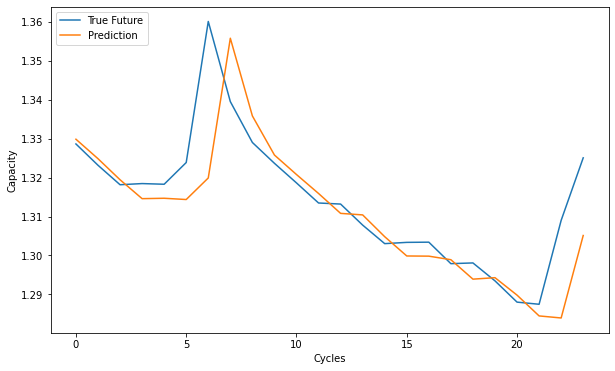

In [47]:
plot_future(predictict, y_test)

In [48]:
############# Calculate RMSE and MAE ##################
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    
    print(model_name + ':')
    print('Mean Absolute Error: ', mae[0])
    print('Root Mean Square Error: ', rmse[0])
    print('')

In [49]:
evaluate_prediction(predictict, y_test, 'LSTM')

LSTM:
Mean Absolute Error:  0.006705367791664363
Root Mean Square Error:  0.011489099185031645

